The aim here is to predict the compressive strength of concrete using mix parameters. Credits - Tensorflow tutorial [Basic regression: Predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression)

This notebook uses the [Concrete Compressive Strength Data](http://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength) dataset. 
This notebook uses the Keras API. 

In [69]:
# Use seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [71]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


## Concrete Compressive Strength Data

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First importing the dataset using pandas:

In [72]:
column_names = ['Cement', 'Slag', 'Flyash', 'Water', 'Superplast',
                'CoarseAgg', 'FineAgg', 'Age', 'Strength']
datafile = 'Concrete_Data.xls'
raw_dataset = pd.read_excel(datafile, names=column_names,
                          na_values='?', comment='\t')

In [73]:
dataset = raw_dataset.copy()
dataset.tail()

,Cement,Slag,Flyash,Water,Superplast,CoarseAgg,FineAgg,Age,Strength
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.401235


### Clean the data

The dataset may contains a few unknown values:

In [74]:
dataset.isna().sum()

Cement        0
Slag          0
Flyash        0
Water         0
Superplast    0
CoarseAgg     0
FineAgg       0
Age           0
Strength      0
dtype: int64

Dropping those rows for simplicity:

In [75]:
dataset = dataset.dropna()

### Split the data into training and test sets

In [76]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Reviewing the joint distribution of a few pairs of columns from the training set.

The top row suggests that the compressive strength is a function of all the other parameters.

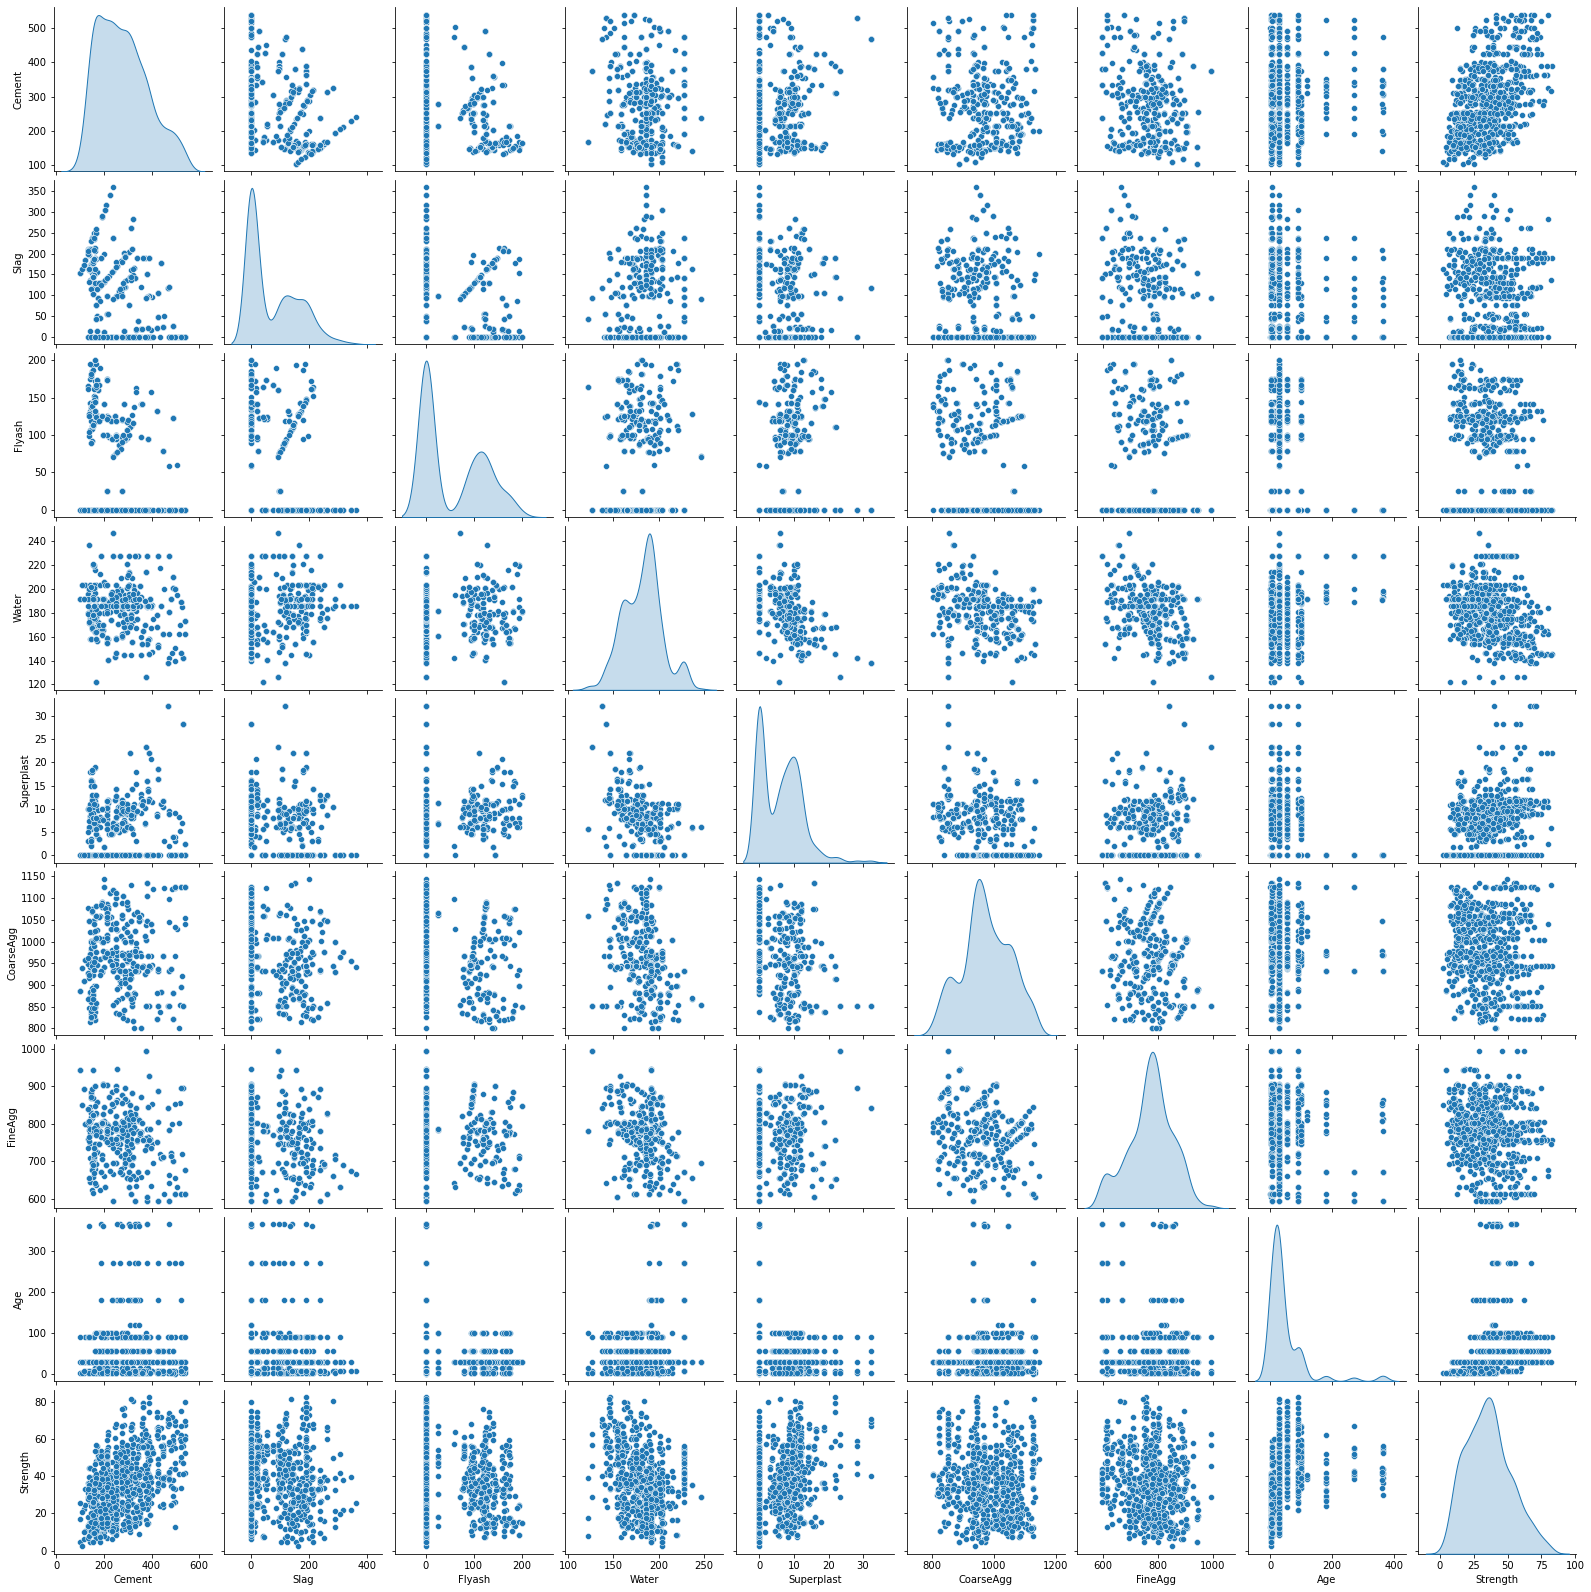

In [77]:
sns.pairplot(train_dataset[['Cement', 'Slag', 'Flyash', 'Water', 'Superplast',
                'CoarseAgg', 'FineAgg', 'Age', 'Strength']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [78]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cement,824.0,280.270971,104.483845,102.000000,193.12500,266.000000,350.000000,540.000000
Slag,824.0,73.170910,85.865408,0.000000,0.00000,22.000000,142.500000,359.400000
Flyash,824.0,55.317124,64.097588,0.000000,0.00000,0.000000,118.270000,200.100000
Water,824.0,182.029053,21.288882,121.750000,164.90000,185.700000,192.000000,247.000000
Superplast,824.0,6.146244,6.000398,0.000000,0.00000,6.100000,10.115000,32.200000
CoarseAgg,824.0,973.990789,77.755716,801.000000,932.00000,968.000000,1030.250000,1145.000000
FineAgg,824.0,771.896408,80.030794,594.000000,721.75000,779.320000,824.000000,992.600000
Age,824.0,45.708738,63.603343,1.000000,7.00000,28.000000,56.000000,365.000000
Strength,824.0,35.739427,16.582077,2.331808,23.52268,34.425537,46.208682,82.599225


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [79]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Strength')
test_labels = test_features.pop('Strength')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [80]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Cement,280.270971,104.483845
Slag,73.170910,85.865408
Flyash,55.317124,64.097588
Water,182.029053,21.288882
Superplast,6.146244,6.000398
CoarseAgg,973.990789,77.755716
FineAgg,771.896408,80.030794
Age,45.708738,63.603343
Strength,35.739427,16.582077


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](../../guide/keras/preprocessing_layers.ipynb) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [81]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [82]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [83]:
print(normalizer.mean.numpy())

[[280.271  73.171  55.317 182.029   6.146 973.991 771.896  45.709]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [84]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 500.    0.    0.  200.    0. 1125.  613.    3.]]

Normalized: [[ 2.1  -0.85 -0.86  0.84 -1.02  1.94 -1.99 -0.67]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

Begin with a single-variable linear regression to predict `'Strength'` from `'Cement'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](.././guide/keras/sequential_model.ipynb).

There are two steps in your single-variable linear regression model:

- Normalize the `'Cement'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Cement'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `Cement` data:

In [85]:
Cement = np.array(train_features['Cement'])

Cement_normalizer = layers.Normalization(input_shape=[1,], axis=None)
Cement_normalizer.adapt(Cement)

Build the Keras Sequential model:

In [86]:
Cement_model = tf.keras.Sequential([
    Cement_normalizer,
    layers.Dense(units=1)
])

Cement_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'Strength'` from `'Cement'`.

Run the untrained model on the first 10 'Cement' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [87]:
Cement_model.predict(Cement[:10])

array([[-1.295],
       [ 0.929],
       [-0.485],
       [-1.425],
       [ 0.727],
       [-0.585],
       [-0.446],
       [ 0.53 ],
       [-1.531],
       [-0.364]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [88]:
Cement_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Having configured the training configured, use Keras `Model.fit` to execute the training for 100 epochs:

In [89]:
%%time
history = Cement_model.fit(
    train_features['Cement'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 2.88 s


Visualize the model's training progress using the stats stored in the `history` object:

In [90]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,11.888912,11.722477,95
96,11.893026,11.796033,96
97,11.877540,11.767818,97
98,11.885582,11.771982,98
99,11.886445,11.777635,99


In [91]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Strength]')
  plt.legend()
  plt.grid(True)

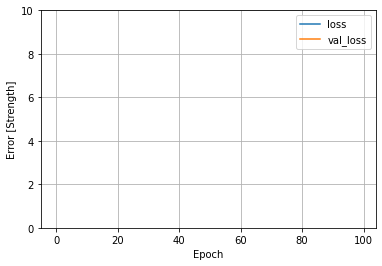

In [92]:
plot_loss(history)

Collect the results on the test set for later:

In [93]:
test_results = {}

test_results['Cement_model'] = Cement_model.evaluate(
    test_features['Cement'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [94]:
x = tf.linspace(0.0, 250, 251)
y = Cement_model.predict(x)

In [95]:
def plot_Cement(x, y):
  plt.scatter(train_features['Cement'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Cement')
  plt.ylabel('Strength')
  plt.legend()

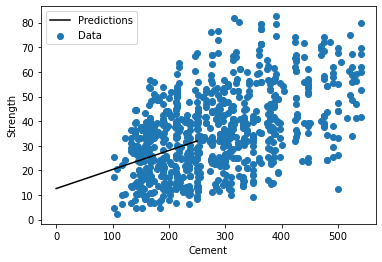

In [96]:
plot_Cement(x,y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [97]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [98]:
linear_model.predict(train_features[:10])

array([[ 1.587],
       [-1.258],
       [-0.397],
       [ 2.602],
       [-1.747],
       [-1.146],
       [-0.735],
       [-0.823],
       [ 1.572],
       [ 1.109]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [99]:
linear_model.layers[1].kernel

<tf.Variable 'dense_6/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.771],
       [-0.749],
       [-0.365],
       [ 0.491],
       [ 0.234],
       [-0.225],
       [ 0.425],
       [-0.176]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [100]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [101]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 3.04 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `Cement_model`, which had one input:

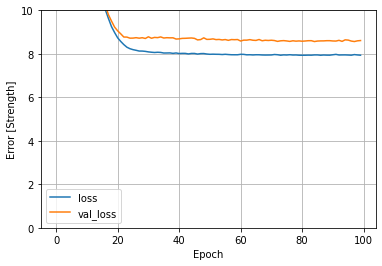

In [102]:
plot_loss(history)

Collect the results on the test set for later:

In [103]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `Cement_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [104]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Cement'` as input and `Cement_normalizer` (defined earlier) as the normalization layer:

In [105]:
dnn_Cement_model = build_and_compile_model(Cement_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [106]:
dnn_Cement_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [107]:
%%time
history = dnn_Cement_model.fit(
    train_features['Cement'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 3.69 s


This model does slightly better than the linear single-input `Cement_model`:

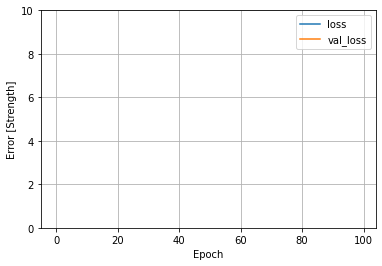

In [108]:
plot_loss(history)

If you plot the predictions as a function of `'Cement'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [109]:
x = tf.linspace(0.0, 250, 251)
y = dnn_Cement_model.predict(x)

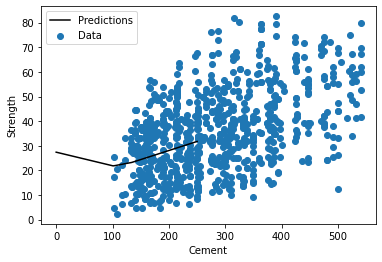

In [110]:
plot_Cement(x, y)

Collect the results on the test set for later:

In [111]:
test_results['dnn_Cement_model'] = dnn_Cement_model.evaluate(
    test_features['Cement'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [112]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_10 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [113]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 3.39 s


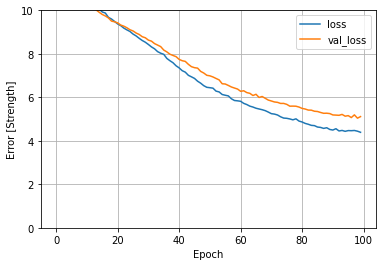

In [114]:
plot_loss(history)

Collect the results on the test set:

In [115]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [116]:
pd.DataFrame(test_results, index=['Mean absolute error [Strength]']).T

,Mean absolute error [Strength]
Cement_model,11.848016
linear_model,8.236053
dnn_Cement_model,11.873081
dnn_model,4.914659


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

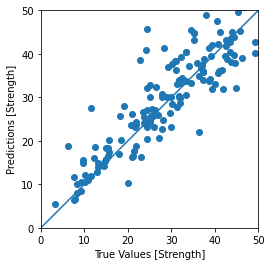

In [117]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Strength]')
plt.ylabel('Predictions [Strength]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

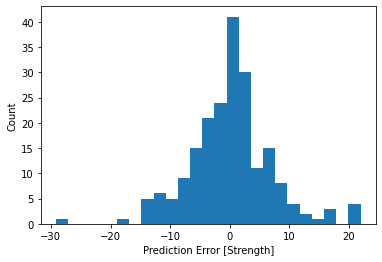

In [118]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Strength]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [119]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


If you reload the model, it gives identical output:

In [120]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [121]:
pd.DataFrame(test_results, index=['Mean absolute error [Strength]']).T

,Mean absolute error [Strength]
Cement_model,11.848016
linear_model,8.236053
dnn_Cement_model,11.873081
dnn_model,4.914659
reloaded,4.914659
